In [1]:
#########################################################################################
##
## Train the Model on Oxford-IIIT Pet Dataset Through Unsupervised Learning
##
## The loss function is based on the ICASSP 2018 paper:
##  Kanezaki, A. (2018). Unsupervised Image Segmentation By Backpropagation. ICASSP, 2–4.
##
## The loss function has an assumption that foreground (cat/dog) and background have
## around 50% probability each.
##
## Author:  Peizhi Yan
##   Date:  Mar. 27, 2021
##
#########################################################################################

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.compat.v1 import keras
from tensorflow.compat.v1.keras import layers

import model.icassp as icassp 
import model.icassp_multiscale as icassp_multiscale

import pet_dataset_handler as pet
from pet_dataset_handler import PetDataGenerator

from cosine_annealing import CosineAnnealingScheduler

import loss


W0401 22:43:43.887155 24112 deprecation.py:323] From C:\Users\yanpe\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\compat\v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
def plot_loss(history, save_path):
    # summarize history for loss
    plt.plot(history.history['loss'], color='indigo')
    plt.plot(history.history['val_loss'], color='deepskyblue')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.savefig(fname=save_path, dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format='pdf',
            transparent=False, bbox_inches=None, pad_inches=0.1,
            frameon=None, metadata=None)
    plt.show()
    
def save_history(history, save_path):
    js = json.dumps(str(history.history))
    f = open(save_path,"w")
    f.write(js)
    f.close()

In [3]:
""" Create the Xception network-based U-Net-like model """
keras.backend.clear_session()
model = icassp.get_model(img_size=(224,224), num_classes=2, M=2)
model.summary()

W0401 10:43:46.527291 21080 deprecation.py:506] From C:\Users\yanpe\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py:1666: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 100)     2800      
_________________________________________________________________
activation (Activation)      (None, 224, 224, 100)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 100)     400       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 100)     90100     
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 100)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 100)     400   

icassp_overseg_mu100_clusters10__aug-True
Featuer Layer:  Tensor("activation_2/Sigmoid:0", shape=(?, 224, 224, 10), dtype=float32)
Epoch 1/50
218/218 [==============================] - 45s 207ms/step - loss: 0.0256 - val_loss: 0.0350 - lr: 0.0010
Epoch 2/50
218/218 [==============================] - 44s 203ms/step - loss: 0.0146 - val_loss: 0.0163 - lr: 9.7577e-04
Epoch 3/50
218/218 [==============================] - 51s 234ms/step - loss: 0.0114 - val_loss: 0.0113 - lr: 9.0546e-04
Epoch 4/50
218/218 [==============================] - 48s 220ms/step - loss: 0.0086 - val_loss: 0.0082 - lr: 7.9595e-04
Epoch 5/50
218/218 [==============================] - 48s 222ms/step - loss: 0.0075 - val_loss: 0.0072 - lr: 6.5796e-04
Epoch 6/50
218/218 [==============================] - 47s 214ms/step - loss: 0.0064 - val_loss: 0.0062 - lr: 5.0500e-04
Epoch 7/50
218/218 [==============================] - 43s 199ms/step - loss: 0.0057 - val_loss: 0.0056 - lr: 3.5204e-04
Epoch 8/50
218/218 [=============

C:\Users\yanpe\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  if sys.path[0] == '':


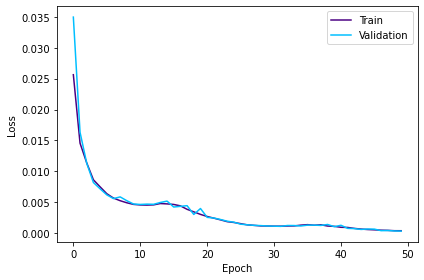

In [194]:
""" Over Segmentation model """

CLUSTERS = 10

for MU in [100]:
    for aug in [True]:
        EXPERIMENT_NAME = 'icassp_overseg_mu'+str(MU)+'_clusters'+str(CLUSTERS)+'__aug-'+str(aug)
        print(EXPERIMENT_NAME)

        if not os.path.exists('./saved_models/'+EXPERIMENT_NAME):
            os.makedirs('./saved_models/'+EXPERIMENT_NAME)

        # Free up RAM in case the model definition cells were run multiple times
        tf.reset_default_graph()
        keras.backend.clear_session()

        BATCH_SIZE = 8

        """ Create the network model """
        model = icassp.get_model(img_size=(224,224), num_classes=CLUSTERS, M=2)
        fea_layer = model.layers[-1].output # we use the second last layer to extract deep feature
        print("Featuer Layer: ", fea_layer)

        """ Create training and validation data generators """
        train_gen = PetDataGenerator(data_path='./data/224x224/train', batch_size=BATCH_SIZE, augmentation=aug, shuffle=True)
        val_gen = PetDataGenerator(data_path='./data/224x224/val', batch_size=BATCH_SIZE, augmentation=False, shuffle=False)

        """ Optimizer """
        opt = keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

        """ Cosine annealing learning rate scheduler """
        cos_annealing = CosineAnnealingScheduler(T_max=10, eta_max=1e-3, eta_min=1e-5)

        """ Automatically save the best model """
        checkpoint = keras.callbacks.ModelCheckpoint('./saved_models/'+EXPERIMENT_NAME+'/{epoch:03d}-{loss:03f}-{val_loss:03f}.h5',
                                                     verbose=0, monitor='val_loss',save_best_only=True, mode='auto')

        """ Compile model """
        model.compile(optimizer=opt, loss=loss.icassp_loss(feature_layer=fea_layer, batch_size=BATCH_SIZE, mu=MU))

        """ Train model """
        callbacks = [checkpoint, cos_annealing]
        #callbacks = [] # for debugging !!
        history = model.fit(train_gen, validation_data=val_gen, epochs=50, verbose=1, callbacks=callbacks)


        """ Save history """
        save_history(history, save_path='./logs/'+EXPERIMENT_NAME+'.json')

        """ Plot history """  
        plot_loss(history, save_path='./plots/'+EXPERIMENT_NAME+'.pdf')

In [3]:
model_overseg = icassp.get_model(img_size=(224,224), num_classes=10, M=2)
model_overseg.load_weights('./saved_models/icassp_overseg_mu100_clusters10__aug-True/050-0.000398-0.000338.h5')

model_binary = icassp.get_model(img_size=(224,224), num_classes=2, M=2)
model_binary.load_weights('./saved_models/icassp_mu100_clusters2__aug-True/050-0.003169-0.003609.h5')

W0401 22:44:25.802546 24112 deprecation.py:506] From C:\Users\yanpe\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py:1666: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


W0401 22:47:23.284610 24112 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0401 22:47:23.314610 24112 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0401 22:47:23.343644 24112 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0401 22:47:23.373651 24112 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0401 22:47:23.402643 24112 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


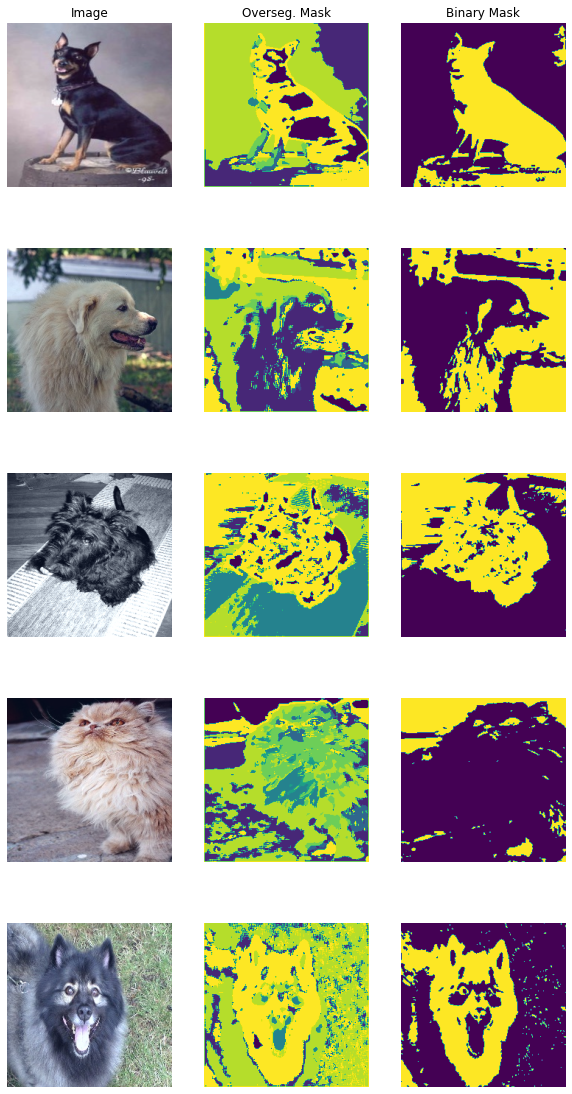

In [11]:
val_gen = PetDataGenerator(data_path='./data/224x224/val', batch_size=5, augmentation=False, shuffle=True)

imgs, masks = val_gen.__getitem__(0)
preds_overseg = np.argmax(model_overseg.predict(imgs), axis=3)
preds_binary = np.argmax(model_binary.predict(imgs), axis=3)

plt.figure(figsize=(10,20))
for i in range(len(imgs)):
    ## Display Images
    plt.subplot(len(imgs),3,i*3+1)
    plt.imshow((imgs[i]+1.9)/3.8)
    if i == 0:
        plt.title('Image')
    plt.axis('off')
    
    ## Display oversegmentation results
    plt.subplot(len(imgs),3,i*3+2)
    plt.imshow(preds_overseg[i])
    plt.axis('off')
    if i == 0:
        plt.title('Overseg. Mask')
        
    ## Display binary segmentation results
    plt.subplot(len(imgs),3,i*3+3)
    plt.imshow(preds_binary[i])
    plt.axis('off')
    if i == 0:
        plt.title('Binary Mask')

(224, 224)
0.9999798912114547
0.3678794411714422
0.7301844670145334


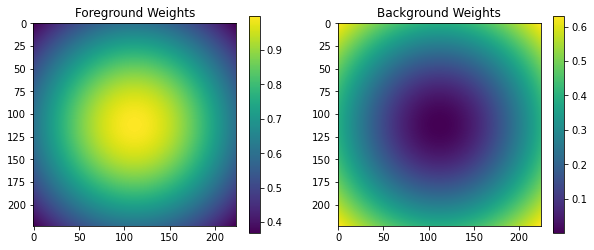

In [9]:
"""2D Gaussian as weights"""
size = 224
x_axis, y_axis = np.meshgrid(np.linspace(-1,1,size), np.linspace(-1,1,size))
d_ = np.sqrt(x_axis*x_axis+y_axis*y_axis)
sigma, mu = 1.0, 0.0
g = np.exp(-( (d_-mu)**2 / ( 2.0 * sigma**2 ) ) )

print(g.shape)
print(g.max())
print(g.min())
print(g.mean())

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(g)
plt.title('Foreground Weights')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(1-g)
plt.title('Background Weights')
plt.colorbar()

In [7]:
preds = model.predict(imgs)



0 0.29468960960254315
1 0.6020594772344344
2 0.4920324032595551
3 0.6303790223969507
4 0.39196954333014095
5 0.34557272474204725
6 0.29760818821266766
7 0.49426816395943396
8 0.4503623800319851
9 0.5000005812202626
[719, 11336, 1005, 16261, 2769, 31, 0, 2401, 3402, 12252]


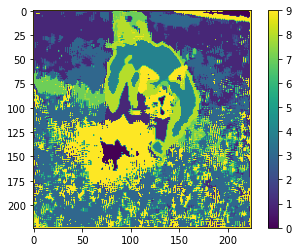

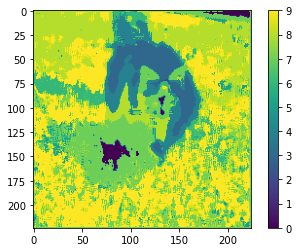

In [12]:
idx = 1

xx = np.argmax(preds[idx],axis=2)
counter = []
weighted_confidences = []
for c in range(CLUSTERS):
    weighted_configence = np.mean(preds[idx,...,c]*g)
    print(c, weighted_configence)
    counter.append(np.sum(xx == c))
    weighted_confidences.append(weighted_configence)
    
print(counter)

sorted_indices = np.argsort(weighted_confidences)

    
plt.imshow(xx)
plt.colorbar()
plt.show()

plt.imshow(np.argmax(np.moveaxis(preds[idx,...,sorted_indices], 0, 2),axis=2))
plt.colorbar()

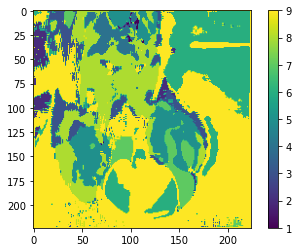

In [11]:
plt.imshow(np.argmax(np.moveaxis(preds[idx,...,sorted_indices], 0, 2),axis=2))
plt.colorbar()

In [252]:
sorted_indices

array([0, 6, 4, 2, 9, 5, 8, 3, 7, 1], dtype=int64)

In [151]:
def gaussian_weights(size):
    x_axis, y_axis = np.meshgrid(np.linspace(-1,1,size), np.linspace(-1,1,size))
    d_ = np.sqrt(x_axis*x_axis+y_axis*y_axis)
    sigma, mu = 1.0, 0.0
    g = np.exp(-( (d_-mu)**2 / ( 2.0 * sigma**2 ) ) )
    w_fg = g # foreground weights
    w_bg = 1 - g # background weights
    w = np.zeros([size, size, 2])
    w[...,0] = w_bg
    w[...,1] = w_fg
    return w


def icassp_loss_posteriors(feature_layer, batch_size, weights, mu=100, fb=1):
    """
    This loss function is a re-implemented and modified version.
    -------------------------------------------------------------------
    Totorial on how to define custon loss in Keras:
        https://towardsdatascience.com/advanced-keras-constructing-
        complex-custom-losses-and-metrics-c07ca130a618
    ===================================================================
    Originally from the ICASSP paper (therefore I named it icassp loss):
         Kanezaki, A. (2018). Unsupervised Image Segmentation By 
         Backpropagation. ICASSP, 2–4.
    Original code (implemented through PyTorch):
        https://github.com/kanezaki/pytorch-unsupervised-segmentation-tip
        /blob/master/demo.py
    -------------------------------------------------------------------
    The loss function has three terms:
        1) feature similarity: pixels with similar deep feature should have
                               higher probability to have the same label;
        2) spatial continuity: pixels that are spatially close should have
                               higher probability to have the same label.
        3) foreground/background loss. 
    """
    # - targ: the label. shape [N,H,W,C]
    # - pred: the predicted mask. shape [N,H,W,C]
    # - mu: weighting factor
    # N: number of samples (batch_size)
    # H: height
    # W: width
    # C: number of classes

    def loss(targ, pred):
        # in fact, targ is not used, because we are doing unsupervised learning
        # the reason for idicating targ as an input parameter is to comply with
        # Keras.
        
        n_classes = int(pred.shape[3]) # number of classes
        n_features = int(feature_layer.shape[3]) # number of features
        
        # c is the pseudo-label (don't forget argmax is not differentiable)
        c = tf.math.argmax(pred, axis=3) # get predicted label
        c = tf.one_hot(indices = c, depth=n_classes) # convert predicted label to pixel-wise one-hot encoding

        """feature similariry loss"""
        loss_sim = 0
        loss_sim = tf.math.reduce_mean(-tf.math.multiply(c, tf.math.log(feature_layer)))

        """continuity loss"""
        loss_con = 0
        fea_y = tf.math.reduce_mean(feature_layer[:,1:,:,:] - feature_layer[:,0:-1,:,:])
        fea_x = tf.math.reduce_mean(feature_layer[:,:,1:,:] - feature_layer[:,:,0:-1,:])
        loss_con_y = tf.norm(fea_y, ord=1) # L1 norm
        loss_con_x = tf.norm(fea_x, ord=1) # L1 norm
        loss_con = loss_con_y + loss_con_x
        
        """fg/bg proportion loss"""
        #loss_fb = 0
        #c0 = tf.math.reduce_mean(pred[...,0])
        #c1 = tf.math.reduce_mean(pred[...,1])
        #loss_fb = tf.math.abs(c0 - c1)
    
        """foreground/background loss"""
        loss_fb = tf.math.reduce_mean(pred * weights)
    
        #return loss_sim + mu*loss_con + fb*loss_fb
        return loss_sim + mu*loss_con + 0.1*loss_fb
    return loss


In [152]:
# This is the last layer of our model (without Softmax!), we use it to extract deep feature :)
model.layers[-1].output

<tf.Tensor 'activation_3/Sigmoid:0' shape=(?, 224, 224, 2) dtype=float32>

# ICASSP Tensorflow-implementation
### $\mu = 1$ and $\mu = 10$
### 2 clusters
### w/ and w/o data augmentation

In [153]:
##MU = 1
CLUSTERS = 2
FB = 1

weights = gaussian_weights(224)


#for MU in [1,10]:
#    for aug in [False, True]:
for MU in [100]:
    for aug in [True]:
        EXPERIMENT_NAME = 'icassp_posteriors_mu'+str(MU)+'_fb'+str(FB)+'_clusters'+str(CLUSTERS)+'__aug-'+str(aug)
        print(EXPERIMENT_NAME)

        if not os.path.exists('./saved_models/'+EXPERIMENT_NAME):
            os.makedirs('./saved_models/'+EXPERIMENT_NAME)

        # Free up RAM in case the model definition cells were run multiple times
        tf.reset_default_graph()
        keras.backend.clear_session()

        BATCH_SIZE = 8

        """ Create the network model """
        model = icassp.get_model(img_size=(224,224), num_classes=CLUSTERS, M=3)
        fea_layer = model.layers[-1].output # we use the second last layer to extract deep feature
        print("Featuer Layer: ", fea_layer)

        """ Create training and validation data generators """
        train_gen = PetDataGenerator(data_path='./data/224x224/train', batch_size=BATCH_SIZE, augmentation=aug, shuffle=True)
        val_gen = PetDataGenerator(data_path='./data/224x224/val', batch_size=BATCH_SIZE, augmentation=False, shuffle=False)

        """ Optimizer """
        opt = keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

        """ Cosine annealing learning rate scheduler """
        cos_annealing = CosineAnnealingScheduler(T_max=10, eta_max=1e-3, eta_min=1e-5)

        """ Automatically save the best model """
        checkpoint = keras.callbacks.ModelCheckpoint('./saved_models/'+EXPERIMENT_NAME+'/{epoch:03d}-{loss:03f}-{val_loss:03f}.h5',
                                                     verbose=0, monitor='val_loss',save_best_only=True, mode='auto')

        """ Compile model """
        model.compile(optimizer=opt, loss=icassp_loss_posteriors(feature_layer=fea_layer, batch_size=BATCH_SIZE,
                                                                 weights=weights, mu=MU, fb=FB))

        """ Train model """
        callbacks = [checkpoint, cos_annealing]
        #callbacks = [] # for debugging !!
        history = model.fit(train_gen, validation_data=val_gen, epochs=50, verbose=1, callbacks=callbacks)


        """ Save history """
        save_history(history, save_path='./logs/'+EXPERIMENT_NAME+'.json')

        """ Plot history """  
        plot_loss(history, save_path='./plots/'+EXPERIMENT_NAME+'.pdf')

icassp_posteriors_mu100_fb1_clusters2__aug-True
Featuer Layer:  Tensor("activation_3/Sigmoid:0", shape=(?, 224, 224, 2), dtype=float32)
Epoch 1/50
218/218 [==============================] - 60s 273ms/step - loss: 0.1791 - val_loss: 0.1811 - lr: 0.0010
Epoch 2/50
218/218 [==============================] - 62s 283ms/step - loss: 0.1313 - val_loss: 0.1394 - lr: 9.7577e-04
Epoch 3/50
218/218 [==============================] - 60s 274ms/step - loss: 0.1080 - val_loss: 0.1014 - lr: 9.0546e-04
Epoch 4/50
218/218 [==============================] - 58s 266ms/step - loss: 0.0928 - val_loss: 0.0906 - lr: 7.9595e-04
Epoch 5/50
218/218 [==============================] - 56s 256ms/step - loss: 0.0823 - val_loss: 0.0815 - lr: 6.5796e-04
Epoch 6/50
218/218 [==============================] - 57s 260ms/step - loss: 0.0760 - val_loss: 0.0737 - lr: 5.0500e-04
Epoch 7/50
218/218 [==============================] - 55s 254ms/step - loss: 0.0716 - val_loss: 0.0728 - lr: 3.5204e-04
Epoch 8/50
218/218 [========

KeyboardInterrupt: 

W0331 19:46:39.354970 25976 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0331 19:46:39.398014 25976 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0331 19:46:39.443017 25976 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0331 19:46:39.484012 25976 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0331 19:46:39.526973 25976 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


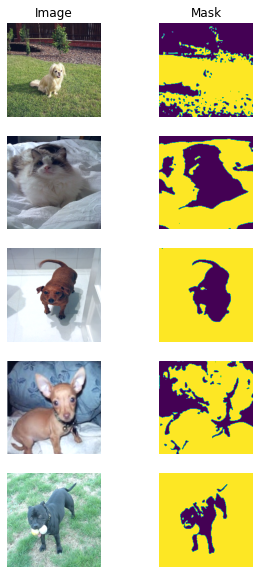

In [176]:
val_gen = PetDataGenerator(data_path='./data/224x224/val', batch_size=5, augmentation=False, shuffle=True)

imgs, masks = val_gen.__getitem__(0)
preds = np.argmax(model.predict(imgs), axis=3)

plt.figure(figsize=(5,10))
for i in range(len(imgs)):
    ## Display Images
    plt.subplot(len(imgs),2,i*2+1)
    plt.imshow((imgs[i]+1.9)/3.8)
    if i == 0:
        plt.title('Image')
    plt.axis('off')
    ## Display Labels
    plt.subplot(len(imgs),2,i*2+2)
    plt.imshow(preds[i])
    plt.axis('off')
    if i == 0:
        plt.title('Mask')

In [10]:
pred

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int64)

In [11]:
mask[50]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.

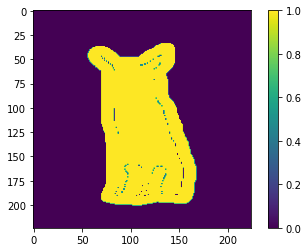

In [12]:
plt.imshow(np.argmax(mask, axis=2))
plt.colorbar()

### Manually Check Model Performance

W0324 17:19:17.819916  2292 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


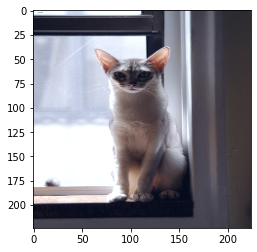

In [13]:
"""
img = cv2.imread('./data/224x224/train/Abyssinian_100.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_ = np.array(img, dtype=np.float32) / 255.

for c in range(3):
    # z-score standardization for each color channel
    img_[:,:,c] = (img_[:,:,c] - pet.mean[c]) / pet.std[c]
"""
 
plt.imshow((img+1.9)/3.8)


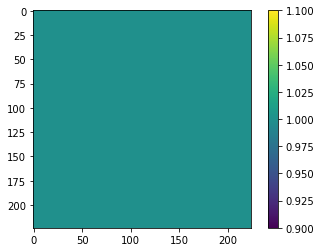

In [14]:
pred = model.predict(np.reshape(img, [-1,224,224,3]))
pred = np.argmax(pred[0], axis=2)
plt.imshow(pred)
plt.colorbar()

In [15]:
pred

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int64)

W0308 22:18:20.976619 40184 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


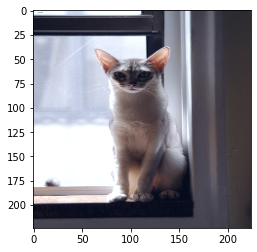

In [80]:
pred = np.reshape(pred, [224,224,1])
plt.imshow(((img+1.9)/3.8) * (np.concatenate([pred, pred, pred], axis=2)))

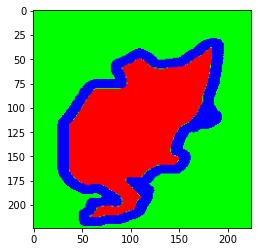

In [28]:
mask = np.load('./data/224x224/train/_Abyssinian_100.npy')

plt.imshow(mask/1.0)

In [6]:
img_, mask_ = pet.data_augmentation(img, mask/1.0, angle_range=(-15,15), scale_range=(0.7,1.3), flip=True)



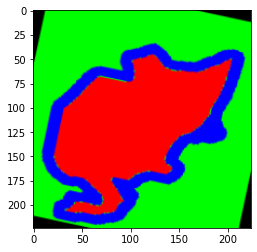

In [7]:
plt.imshow(mask_)

In [32]:
mask[50]


array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

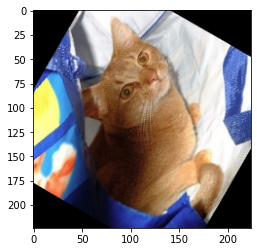

In [8]:
plt.imshow(pet.rotate(image=img, angle=60))

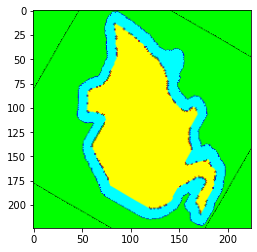

In [14]:
mask_ = pet.rotate(image=mask/1.0, angle=60)
mask_ = np.where(mask_ == [0,0,0], [0,1.0,0] ,mask_)
plt.imshow(mask_)

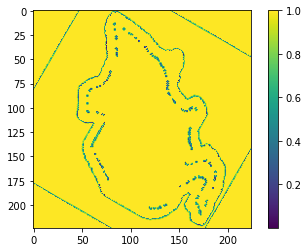

In [22]:
plt.imshow(mask_[:,:,1])
plt.colorbar()

In [12]:
mask/1.0

array([[[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        ...,
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]],

       [[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        ...,
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]],

       [[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        ...,
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]],

       ...,

       [[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        ...,
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]],

       [[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        ...,
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]],

       [[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        ...,
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]]])

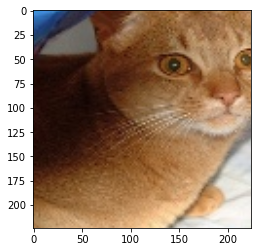

In [9]:
plt.imshow(pet.scale(image=img, scale=2.0))

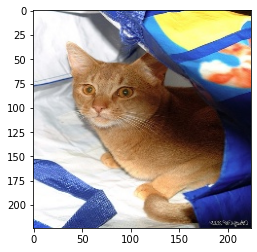

In [10]:
plt.imshow(pet.flip(image=img, vertical=False, horizontal=True))

In [85]:
import random

random.uniform(0, 2.0)

0.9643677775999517